# Dimensionality Reduction with MNIST

In [7]:
from sklearn.datasets import fetch_openml

# 784 pixel로 이뤄진 mnist 이미지 데이터 호출 (28x28)
mnist = fetch_openml("mnist_784",version=1)

X = mnist.data / 255.0
y = mnist.target
print("X shape: ",X.shape)
print("Y shape: ",y.shape)

X shape:  (70000, 784)
Y shape:  (70000,)


In [2]:
n_image = X.shape[0]
n_image_pixel = X.shape[1]

pixel_columns = [ f"pixel{i}" for i in range(n_image_pixel) ] #  픽셀정보가 있는 칼럼의 이름을 담은 목록
len(pixel_columns)

784

In [8]:
# data frame으로 만들기
import pandas as pd

df = pd.DataFrame(X,columns=pixel_columns)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i)) # 숫자 라벨을 스트링으로 만드는 함수를 파이썬 람다 문법으로 전체 데이터에 적용합니다.
X, y = None, None

In [9]:
# 10000개 random smapling
import numpy as np

# 결과가 재생산 가능하도록 랜덤 시드를 지정합니다.
np.random.seed(30)

# 이미지 데이터의 순서를 랜덤으로 뒤바꾼(permutation) 배열을 담습니다.
rndperm = np.random.permutation(n_image)

# 랜덤으로 섞은 이미지 중 10,000개를 뽑고, df_subset에 담습니다.
n_image_sample = 10000
random_idx = rndperm[:n_image_sample]
df_subset = df.loc[rndperm[:n_image_sample],:].copy()
df_subset.shape

(10000, 786)

<Figure size 432x288 with 0 Axes>

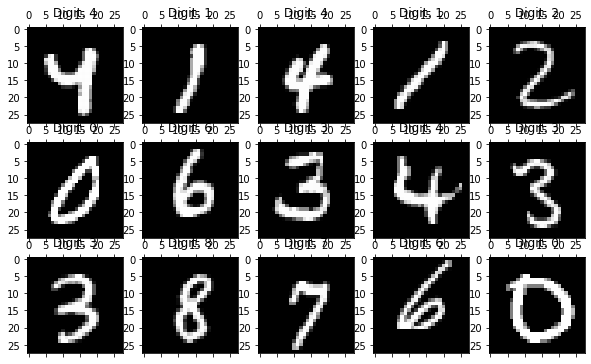

In [10]:
# 확인
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.gray()
fig = plt.figure( figsize=(10,6) )
n_img_sample = 15
width,height = 28,28

# 15개 샘플을 시각화해 봅니다. 
for i in range(0,n_img_sample):
    row = df_subset.iloc[i]
    ax = fig.add_subplot(3,5,i+1, title=f"Digit: {row['label']}")
    ax.matshow(row[pixel_columns]
               .values.reshape((width,height))
               .astype(float))

plt.show()

## PCA
- scikit-learn fit_transform

In [21]:
from sklearn.decomposition import PCA

df_subset = df.loc[rndperm[:n_image_sample],:].copy()
print("df_subset의 shape: {}".format(df_subset.shape))

n_dimension = 2 # 축소시킬 목표 차원의 수
pca = PCA(n_components=n_dimension)

pca_result = pca.fit_transform(df_subset[pixel_columns].values) # 차원을 축소한 결과
df_subset['pca-one'] = pca_result[:,0] # 축소한 결과의 첫 번째 차원 값
df_subset['pca-two'] = pca_result[:,1] # 축소한 결과의 두 번째 차원 값

print("pca_result의 shape: {}".format(pca_result.shape))

df_subset의 shape: (10000, 786)
pca_result의 shape: (10000, 2)


In [12]:
# 보존하는 정보량 확인 => 16.9%
print(f"pca-1: {round(pca.explained_variance_ratio_[0],3)*100}%")
print(f"pca-2: {round(pca.explained_variance_ratio_[1],3)*100}%")

pca-1: 9.6%
pca-2: 7.3%


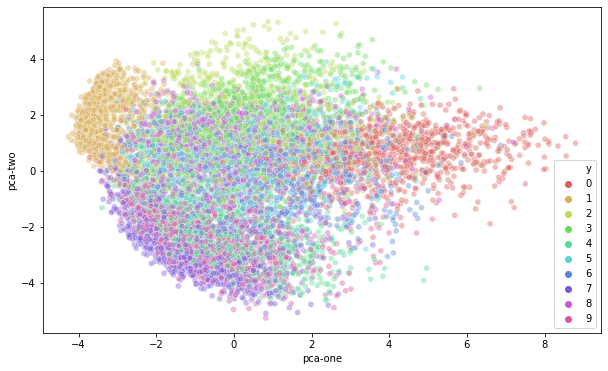

In [13]:
# 784차원을 2차원으로 줄인 결과 
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,   # 2개의 PC축만 남은 데이터프레임 df_subset 을 시각화해 보자.
    legend="full",
    alpha=0.4
)

In [15]:
n_dimension = 3 # 축소시킬 목표 차원의 수
pca = PCA(n_components=n_dimension)

# 3차원 축소 후 남은 정보량 계산하기
pca_result = pca.fit_transform(df_subset[pixel_columns].values) # 차원을 축소한 결과
df_subset['pca-one'] = pca_result[:,0] # 축소한 결과의 첫 번째 차원 값
df_subset['pca-two'] = pca_result[:,1] # 축소한 결과의 두 번째 차원 값
df_subset['pca-three'] = pca_result[:,2] # 축소한 결과의 세 번째 차원 값

print("pca_result의 shape: {}".format(pca_result.shape))

print(f"pca-1: {round(pca.explained_variance_ratio_[0],3)*100}%")
print(f"pca-2: {round(pca.explained_variance_ratio_[1],3)*100}%")
print(f"pca-3: {round(pca.explained_variance_ratio_[2],3)*100}%")


pca_result의 shape: (10000, 3)
pca-1: 9.6%
pca-2: 7.3%
pca-3: 6.1%


<Figure size 432x288 with 0 Axes>

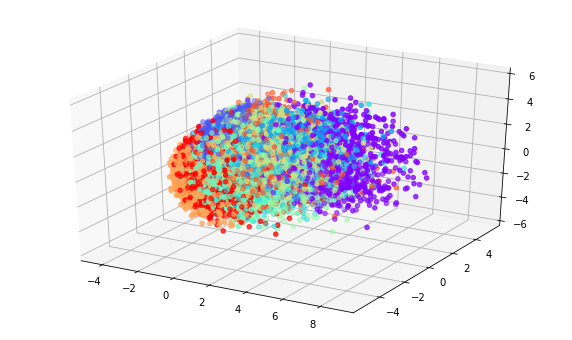

In [16]:
# 3차원으로 시각화하기
fig = plt.figure()
ax = plt.figure(figsize=(10,6)).gca(projection='3d')
ax.scatter(
    xs=df_subset["pca-one"], 
    ys=df_subset["pca-two"], 
    zs=df_subset["pca-three"], 
    c=df_subset["label"].map(lambda x : int(x)), 
    cmap=plt.cm.get_cmap('rainbow', 10)
)
plt.show()

## T-SNE
- scikit-learn fransform
- 기존 차원에서도 가까운 점들은 차원 축소 후에도 여전히 가까움. 시각화하여 확인할 수 있음.
- PCA 같은 경우에는 두 점 사이의 거리 정보가 손실됨.

In [24]:
from sklearn.manifold import TSNE

df_subset = df.loc[rndperm[:n_image_sample],:].copy()
print("df_subset의 shape: {}".format(df_subset.shape))

data_subset = df_subset[pixel_columns].values
n_dimension = 2
tsne = TSNE(n_components=n_dimension)
tsne_results = tsne.fit_transform(data_subset)

print("tsne_results의 shape: {}".format(tsne_results.shape))

df_subset의 shape: (10000, 786)
tsne_results의 shape: (10000, 2)


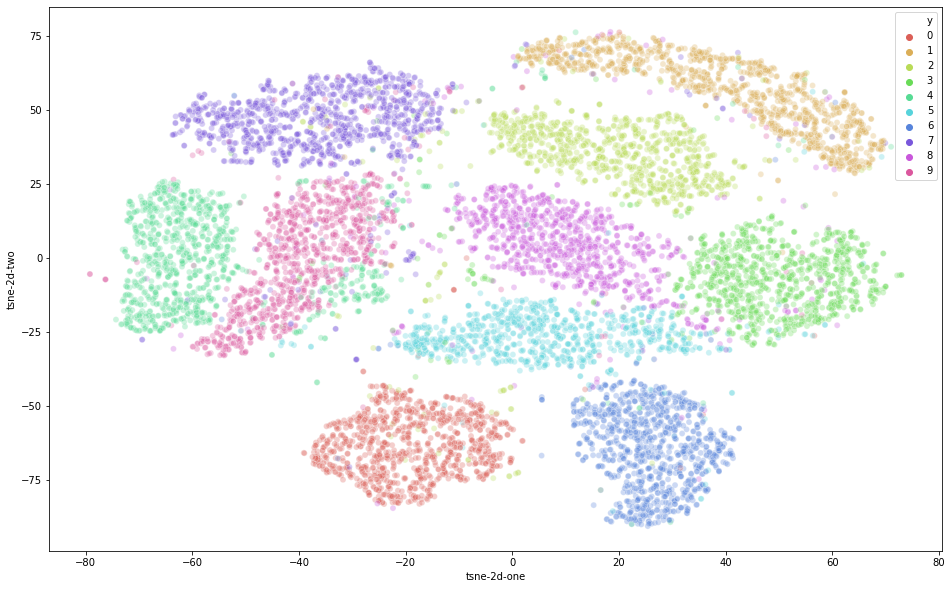

In [23]:
# tsne 결과를 차원별로 추가합니다.
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

# 시각화해 봅니다.
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [25]:
df_subset = df.loc[rndperm[:n_image_sample],:].copy()
print("df_subset의 shape: {}".format(df_subset.shape))

data_subset = df_subset[pixel_columns].values

n_dimension = 3
tsne = TSNE(n_components=n_dimension)
tsne_results = tsne.fit_transform(data_subset)

print("tsne_results의 shape: {}".format(tsne_results.shape))

df_subset의 shape: (10000, 786)
tsne_results의 shape: (10000, 3)


<Figure size 432x288 with 0 Axes>

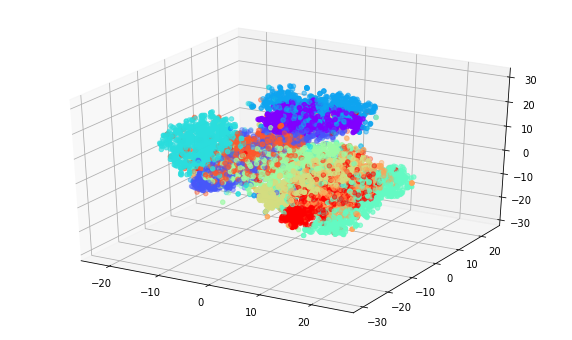

In [27]:
# tsne 결과를 차원별로 추가합니다.
df_subset['tsne-3d-one'] = tsne_results[:,0]
df_subset['tsne-3d-two'] = tsne_results[:,1]
df_subset['tsne-3d-three'] = tsne_results[:,2]

# 3차원으로 시각화하기
fig = plt.figure()
ax = plt.figure(figsize=(10,6)).gca(projection='3d')
ax.scatter(
    xs=df_subset["tsne-3d-one"], 
    ys=df_subset["tsne-3d-two"], 
    zs=df_subset["tsne-3d-three"], 
    c=df_subset["label"].map(lambda x : int(x)), 
    cmap=plt.cm.get_cmap('rainbow', 10)
)
plt.show()

# Word2vec Dimension Reduction

In [29]:
import os
from gensim.models import Word2Vec

# 다운로드받은 Word2vec 파일을 gensim Word2Vec 모델로 읽어들입니다.
word2vec_path = os.getenv('HOME')+'/aiffel/dimensionality_reduction/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

# word vector 부분을 모아서 Numpy Array로 만들어 줍니다. 
X = np.array([word2vec.wv[word] for word in word2vec.wv.vocab])
print("X shape: ",X.shape)

X shape:  (30185, 200)


In [30]:
n_word2vec = X.shape[0]
n_word2vec_dim = X.shape[1]

vector_cols = [ f"wv_{i}" for i in range(n_word2vec_dim) ] #  word vector 각 칼럼의 이름을 담은 목록
print(len(vector_cols))
vector_cols[:5]

200


['wv_0', 'wv_1', 'wv_2', 'wv_3', 'wv_4']

In [31]:
word2vec_df = pd.DataFrame(X,columns=vector_cols)
word2vec_df['word'] = word2vec.wv.vocab

word2vec_df

,wv_0,wv_1,wv_2,wv_3,wv_4,wv_5,wv_6,wv_7,wv_8,wv_9,...,wv_191,wv_192,wv_193,wv_194,wv_195,wv_196,wv_197,wv_198,wv_199,word
0,0.500703,-0.881331,0.840488,-1.011043,-0.470924,0.650730,-0.898005,0.357132,-0.950456,0.509048,...,0.516708,-1.368798,-0.524154,-0.121826,1.282774,0.391413,0.456243,-1.375120,-1.298401,관위
1,0.547093,-0.152805,0.128781,0.118195,0.158063,0.250073,0.401098,0.419098,0.185329,0.145870,...,0.376673,0.280429,-0.133996,-0.042347,0.193313,0.144560,0.167356,0.115034,-0.055788,정어리
2,-0.210893,0.592757,0.433207,0.471359,0.327533,-0.220485,0.531203,0.795377,-0.123786,0.168221,...,-0.667890,1.165300,-0.660963,0.366856,0.690725,-0.738749,0.377058,0.931111,-0.137286,유식론
3,1.121378,-0.293296,-0.101475,1.506765,-0.327073,0.663991,0.185524,0.583172,-0.389802,-1.381693,...,-1.327527,0.469743,-1.219686,0.232114,0.543071,-0.471700,0.671543,-0.361913,-0.447926,장로회
4,-0.005707,0.068217,-0.217653,0.603975,0.884008,0.686472,0.144199,0.174264,-0.255747,0.525165,...,-0.247714,-0.118415,-0.855486,1.105105,0.993783,0.256637,-0.370218,0.602079,-0.080047,춘추관
5,-0.621576,-0.707224,0.057663,0.082802,-0.105962,-0.035220,-0.069962,0.385961,0.278192,0.800118,...,0.082945,-0.222754,0.032390,-0.152281,0.181077,-0.080807,-0.150208,-0.001113,0.325522,도입부
6,0.730789,0.624155,-0.898584,0.501511,0.128065,-0.702606,-0.048158,1.144122,0.529141,-0.597529,...,0.352043,-0.059362,0.095871,-0.895442,0.140458,-0.636831,-0.254466,0.539444,0.243757,민병
7,0.760087,0.737920,-0.675374,-0.351398,-0.737258,-1.335981,-0.921290,-0.437233,-2.415599,-2.466390,...,0.520002,0.832649,-1.998514,4.168946,-2.039200,-0.673193,2.345596,-0.754447,3.720312,어렵
8,-1.364616,-0.428923,1.048548,0.091761,-0.521663,-0.182839,0.994809,0.238317,-0.249490,-0.447581,...,0.173547,-1.584700,0.600566,0.018785,-0.172016,-0.673717,-0.459290,0.798099,0.293478,매니저
9,0.228880,0.084008,0.231583,0.038759,-0.175509,0.285116,0.140274,0.125168,0.105616,0.160167,...,0.027664,0.409172,-0.017964,0.327987,0.411212,-0.110302,-0.460576,0.302143,-0.235770,청담


## PCA

In [32]:
word2vec_df2 = word2vec_df
print("word2vec_df2의 shape: {}".format(word2vec_df2.shape))

n_dimension = 2 # 축소시킬 목표 차원의 수
pca = PCA(n_components=n_dimension)

pca_result = pca.fit_transform(word2vec_df2[vector_cols].values) # 차원을 축소한 결과
word2vec_df2['pca-one'] = pca_result[:,0] # 축소한 결과의 첫 번째 차원 값
word2vec_df2['pca-two'] = pca_result[:,1] # 축소한 결과의 두 번째 차원 값

print("pca_result의 shape: {}".format(pca_result.shape))

df_subset의 shape: (30185, 201)
pca_result의 shape: (30185, 2)


In [33]:
# 보존하는 정보량 확인 => 16.9%
print(f"pca-1: {round(pca.explained_variance_ratio_[0],3)*100}%")
print(f"pca-2: {round(pca.explained_variance_ratio_[1],3)*100}%")

pca-1: 5.200000107288361%
pca-2: 4.600000008940697%


In [50]:
font_list = fm.findSystemFonts(fontpaths='/usr/share/fonts', fontext='ttf')
font_list[0:100]
#[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

['/usr/share/fonts/opentype/noto/NotoSerifCJK-SemiBold.ttc',
 '/usr/share/fonts/truetype/kacst/KacstScreen.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-BoldOblique.ttf',
 '/usr/share/fonts/opentype/malayalam/Manjari-Bold.otf',
 '/usr/share/fonts/truetype/tlwg/Umpush.ttf',
 '/usr/share/fonts/truetype/Gubbi/Gubbi.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/kacst/KacstNaskh.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-Bold.ttf',
 '/usr/share/fonts/opentype/noto/NotoSansCJK-Thin.ttc',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf',
 '/usr/share/fonts/truetype/tlwg/TlwgTypist-Bold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Oblique.ttf',
 '/usr/share/fonts/truetype/freefont/FreeSansBoldOblique.ttf',
 '/usr/share/fonts/truetype/roboto/hinted/RobotoCondensed-Light.ttf',
 '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc',
 '/usr/share/fonts/truetype/freefont/FreeSansBold.ttf',
 '/usr/share/fonts/tru

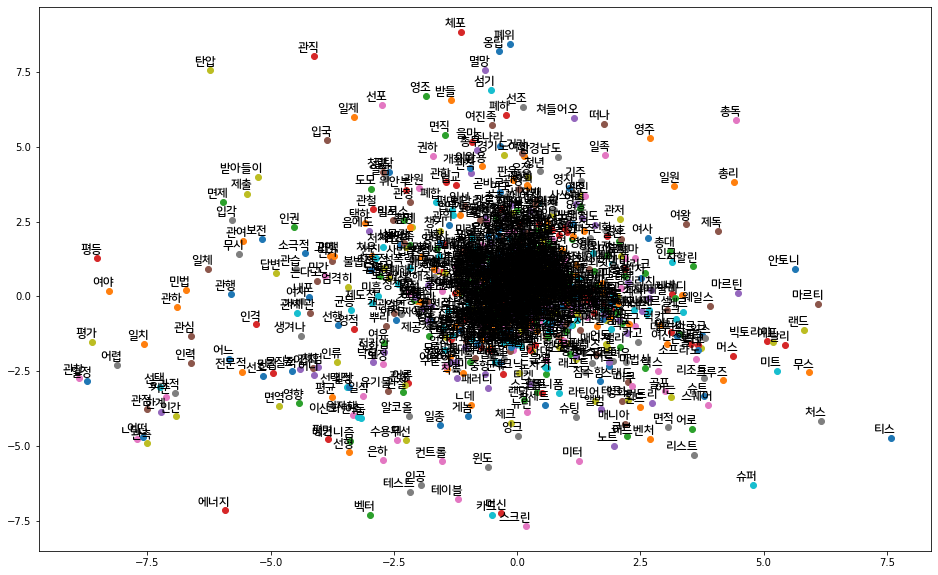

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 한글폰트 생성
font_path = '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)

# matplot 으로 시각화 하여 결과를 어떤 단어들이 가까이 존재하는지 확인하기
plt.figure(figsize=(16,10))
for i, label in enumerate(word2vec_df2["word"][:1000]): 
    if len(word2vec_df2["word"][i])==1:
        continue
    x= word2vec_df2["pca-one"][i] 
    y = word2vec_df2["pca-two"][i] 
    plt.scatter(x, y) 
    plt.annotate(label, 
                 xy=(x, y), xytext=(5, 2), 
                 textcoords='offset points', 
                 ha='right', va='bottom', 
                 fontproperties=fontprop)   # 한글폰트 적용
plt.show()

## T-SNE

In [53]:
from sklearn.manifold import TSNE
word2vec_df2 = word2vec_df
print("word2vec_df2의 shape: {}".format(word2vec_df2.shape))

data_subset = word2vec_df2[vector_cols].values
n_dimension = 2
tsne = TSNE(n_components=n_dimension)
tsne_results = tsne.fit_transform(data_subset)
word2vec_df2['tsne-2d-one'] = tsne_results[:,0]
word2vec_df2['tsne-2d-two'] = tsne_results[:,1]

print("tsne_result의 shape: {}".format(tsne_results.shape))

word2vec_df2의 shape: (30185, 203)
tsne_result의 shape: (30185, 2)


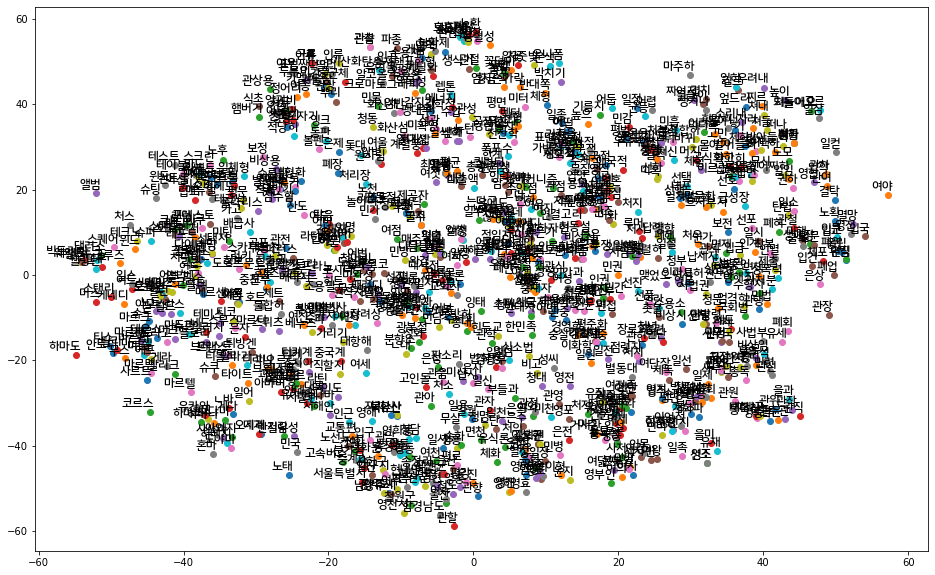

In [56]:
plt.figure(figsize=(16,10))
for i, label in enumerate(word2vec_df2["word"][:1000]): 
    if len(word2vec_df2["word"][i])==1:
        continue
    x= word2vec_df2["tsne-2d-one"][i] 
    y = word2vec_df2["tsne-2d-two"][i] 
    plt.scatter(x, y) 
    plt.annotate(label, 
                 xy=(x, y), xytext=(5, 2), 
                 textcoords='offset points', 
                 ha='right', va='bottom',
                 fontproperties=fontprop)   # 한글폰트 적용) 
plt.show()